In [1]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.metrics import categorical_crossentropy
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense, AvgPool2D,MaxPool2D
from keras.models import Sequential, Model
# from keras.optimizers import  SGD, RMSprop
from tensorflow.keras.optimizers import Adam,SGD, RMSprop
from keras import backend as K
import cv2
import shutil
import glob

In [2]:
# Those metrics are all global metrics, but Keras works in batches. As a result, it might be more misleading than helpful.
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [3]:
data = os.getcwd()
No_brain_tumor = './data/no'
Yes_brain_tumor = './data/yes'

In [4]:
dirlist=[No_brain_tumor, Yes_brain_tumor]
classes=['No', 'Yes']
filepaths=[]
labels=[]
for i,j in zip(dirlist, classes):
    filelist=os.listdir(i)
    for f in filelist:
        filepath=os.path.join (i,f)
        filepaths.append(filepath)
        labels.append(j)
print ('filepaths: ', len(filepaths), '   labels: ', len(labels))

filepaths:  253    labels:  253


In [5]:
Files=pd.Series(filepaths, name='filepaths')
Label=pd.Series(labels, name='labels')
df=pd.concat([Files,Label], axis=1)
df=pd.DataFrame(np.array(df).reshape(253,2), columns = ['filepaths', 'labels'])
df.head()

,filepaths,labels
0,./data/no\1 no.jpeg,No
1,./data/no\10 no.jpg,No
2,./data/no\11 no.jpg,No
3,./data/no\12 no.jpg,No
4,./data/no\13 no.jpg,No


In [6]:
df['labels'].value_counts()

Yes    155
No      98
Name: labels, dtype: int64

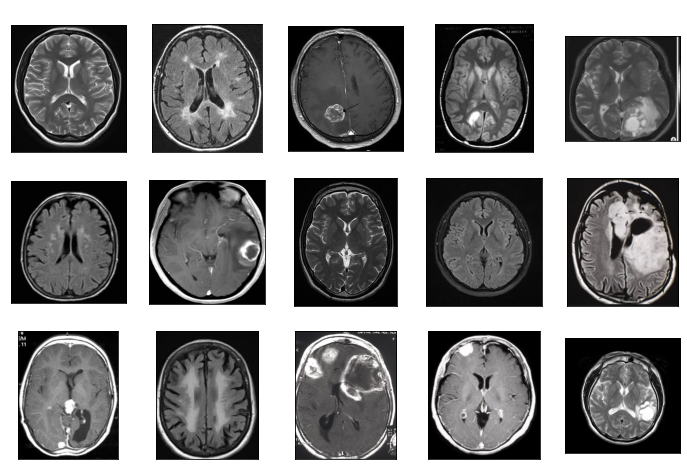

In [7]:
plt.figure(figsize=(12,8))
for i in range(15):
    random = np.random.randint(1,len(df))
    plt.subplot(3,5,i+1)
    plt.imshow(cv2.imread(df.loc[random,"filepaths"]))
    plt.title(df.loc[random, "labels"], size = 15, color = "white") 
    plt.xticks([])
    plt.yticks([])
    
plt.show()

In [8]:
from sklearn.model_selection import train_test_split
# wroc tutaj do klasyfikacji
train, test = train_test_split(df, train_size=0.95, random_state=0)
train_new, valid = train_test_split(train, train_size=0.90, random_state=0)

print(f"train set shape: {train_new.shape}")
print(f"test set shape: {test.shape}")
print(f"validation set shape: {valid.shape}")

train set shape: (216, 2)
test set shape: (13, 2)
validation set shape: (24, 2)


In [9]:
train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, 
                                   shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True, vertical_flip =True)
test_datagen = ImageDataGenerator(rescale = 1.0/255.)

In [10]:
train_gen = train_datagen.flow_from_dataframe(dataframe = train_new,
                                              x_col = 'filepaths', y_col ='labels',
                                              target_size = (150,150), batch_size = 16, 
                                              class_mode = 'binary', shuffle = True)
val_gen = train_datagen.flow_from_dataframe(valid, 
                                            target_size=(150,150), x_col = 'filepaths', y_col ='labels', 
                                            class_mode='binary',
                                            batch_size= 16, shuffle=True)
test_gen = test_datagen.flow_from_dataframe(test,
                                            target_size = (150,150), x_col = 'filepaths', y_col ='labels',
                                             class_mode = 'binary',
                                            batch_size = 16, shuffle = False)

Found 216 validated image filenames belonging to 2 classes.
Found 24 validated image filenames belonging to 2 classes.
Found 13 validated image filenames belonging to 2 classes.


In [11]:
train_gen.class_indices

{'No': 0, 'Yes': 1}

In [12]:
base_model = tf.keras.applications.InceptionResNetV2(weights='imagenet', input_shape = (200,200,3),
                                                     include_top=False)
    
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 4, 4, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               196736    
                                                                 
 batch_normalization_203 (Ba  (None, 128)              512       
 tchNormalization)                                               
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                        

In [13]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("Tumor_classifier_model.h5", save_best_only=True, verbose = 0),
    tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss', verbose=1),
]




# adding own metrics has no sense, but in the name of science I wanted to try it on my own
model.compile(loss='binary_crossentropy', optimizer=Adam(lr = 0.0001), metrics=['acc',f1_m,precision_m, recall_m])


history = model.fit(train_gen, validation_data = val_gen, epochs = 40, 
                    callbacks = [callbacks], verbose = 1)

C:\Users\Admin\Envs\deepl\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/40
14/14 [==============================] - 65s 3s/step - loss: 0.8137 - acc: 0.5741 - f1_m: 0.6241 - precision_m: 0.7034 - recall_m: 0.5816 - val_loss: 0.7279 - val_acc: 0.4583 - val_f1_m: 0.4732 - val_precision_m: 0.6667 - val_recall_m: 0.4143
Epoch 2/40
14/14 [==============================] - 45s 3s/step - loss: 0.5062 - acc: 0.7454 - f1_m: 0.7597 - precision_m: 0.8495 - recall_m: 0.7178 - val_loss: 0.6318 - val_acc: 0.6667 - val_f1_m: 0.6500 - val_precision_m: 0.7500 - val_recall_m: 0.5833
Epoch 3/40
14/14 [==============================] - 42s 3s/step - loss: 0.5170 - acc: 0.7778 - f1_m: 0.8092 - precision_m: 0.8675 - recall_m: 0.7680 - val_loss: 0.4380 - val_acc: 0.7917 - val_f1_m: 0.7024 - val_precision_m: 1.0000 - val_recall_m: 0.5571
Epoch 4/40
14/14 [==============================] - 42s 3s/step - loss: 0.3679 - acc: 0.8380 - f1_m: 0.8574 - precision_m: 0.9341 - recall_m: 0.8033 - val_loss: 0.3727 - val_acc: 0.8750 - val_f1_m: 0.8417 - val_precision_m: 0.8750 - val_r

In [14]:
print(history.history.keys())

dict_keys(['loss', 'acc', 'f1_m', 'precision_m', 'recall_m', 'val_loss', 'val_acc', 'val_f1_m', 'val_precision_m', 'val_recall_m'])


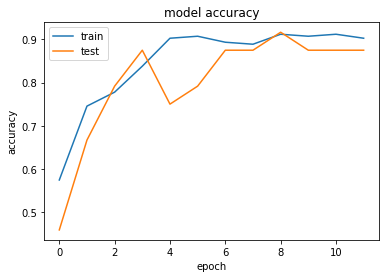

In [15]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


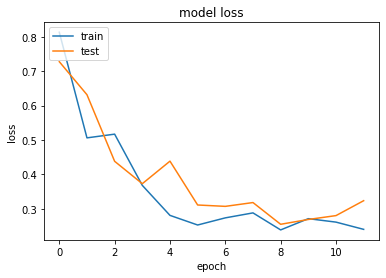

In [16]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [17]:
model.load_weights("Tumor_classifier_model.h5")
model.evaluate(test_gen)

1/1 [==============================] - 1s 749ms/step - loss: 0.3329 - acc: 0.8462 - f1_m: 0.9000 - precision_m: 1.0000 - recall_m: 0.8182


[0.3328739404678345,
 0.8461538553237915,
 0.8999999165534973,
 1.0,
 0.8181818127632141]

In [18]:


model.evaluate(train_gen)

14/14 [==============================] - 9s 635ms/step - loss: 0.5080 - acc: 0.9259 - f1_m: 0.9294 - precision_m: 0.9851 - recall_m: 0.8873


[0.5080083012580872,
 0.9259259104728699,
 0.9294034838676453,
 0.9851190447807312,
 0.8872776031494141]

In [21]:
sample_image = cv2.imread('./data/no/no_1.jpg')


In [19]:
sample = test_datagen.flow_from_dataframe(test.head(2),
                                            target_size = (150,150), x_col = 'filepaths', y_col ='labels',
                                             class_mode = 'binary',
                                            batch_size = 16, shuffle = False)

Found 2 validated image filenames belonging to 2 classes.


In [29]:
pred = model.predict(sample)
classes_x=np.argmax(pred,axis=1)
classes_x


array([0, 0], dtype=int64)